In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# @title Запуск тестов из папки tests
%cd "/content/drive/MyDrive/stocks/pretrained_rl_ppo"
!pytest -q



/content/drive/MyDrive/stocks/pretrained_rl_ppo
.............................                                            [100%]
29 passed in 15.46s


In [ ]:
# @title Проверка среды на синтетических данных LONG

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig


def generate_sine_data(n=200, fast_window=5, slow_window=20):
    """Generate sinusoidal price data with moving averages and signals."""
    t = np.arange(n)
    price = 100 + 10 * np.sin(2 * np.pi * t / 50)
    df = pd.DataFrame({'close': price})
    df['fast_ma'] = df['close'].rolling(window=fast_window).mean()
    df['slow_ma'] = df['close'].rolling(window=slow_window).mean()
    df.dropna(inplace=True)
    fast = df['fast_ma']
    slow = df['slow_ma']
    signal = np.zeros(len(df), dtype=int)
    signal[(fast > slow) & (fast.shift(1) <= slow.shift(1))] = 1
    signal[(fast < slow) & (fast.shift(1) >= slow.shift(1))] = -1
    df['signal'] = signal
    return df.reset_index(drop=True)


def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['signal']:
        action = 0
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.00005,         # без комиссии
    spread=0.0005,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

#проверка лонгов
df = generate_sine_data()
environment = BacktestEnv(df, feature_cols=['fast_ma', 'slow_ma'], cfg = LONG_CONFIG)
sim = run_backtest(df, environment)
logs = sim.logs()
print(logs.head(50).to_string())
print('Метрики: ')
print(sim.metrics_report())
fig = sim.plot()


In [ ]:
# @title Проверка среды на синтетических данных SHORT

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig


def generate_sine_data(n=500, fast_window=5, slow_window=20):
    """Generate sinusoidal price data with moving averages and signals."""
    t = np.arange(n)
    price = 100 + 10 * np.sin(2 * np.pi * t / 50)
    df = pd.DataFrame({'close': price})
    df['fast_ma'] = df['close'].rolling(window=fast_window).mean()
    df['slow_ma'] = df['close'].rolling(window=slow_window).mean()
    df.dropna(inplace=True)
    fast = df['fast_ma']
    slow = df['slow_ma']
    signal = np.zeros(len(df), dtype=int)
    signal[(fast < slow) & (fast.shift(1) >= slow.shift(1))] = 1
    signal[(fast > slow) & (fast.shift(1) <= slow.shift(1))] = -1
    df['signal'] = signal
    return df.reset_index(drop=True)


def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['signal']:
        action = 0
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

SORT_CONFIG = EnvConfig(
    mode=-1,          # работаем только от длинной позиции
    fee=0.00005,         # без комиссии
    spread=0.000,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

#проверка лонгов
df = generate_sine_data()
environment = BacktestEnv(df, feature_cols=['fast_ma', 'slow_ma'], cfg = SORT_CONFIG)
sim = run_backtest(df, environment)
logs = sim.logs()
print(logs.head(50).to_string())
print(sim.metrics_report())
fig = sim.plot()


     t    price  position  entry_price    reward    equity  realized_pnl  unrealized_pnl  opened  closed  exec_price  pnl_trade
0    1  0.08958         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
1    2  0.08963         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
2    3  0.08962         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
3    4  0.08974         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
4    5  0.08977         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
5    6  0.08980         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False    0.000000        0.0
6    7  0.08982         0     0.000000  0.000000  0.000000      0.000000        0.000000   False   False

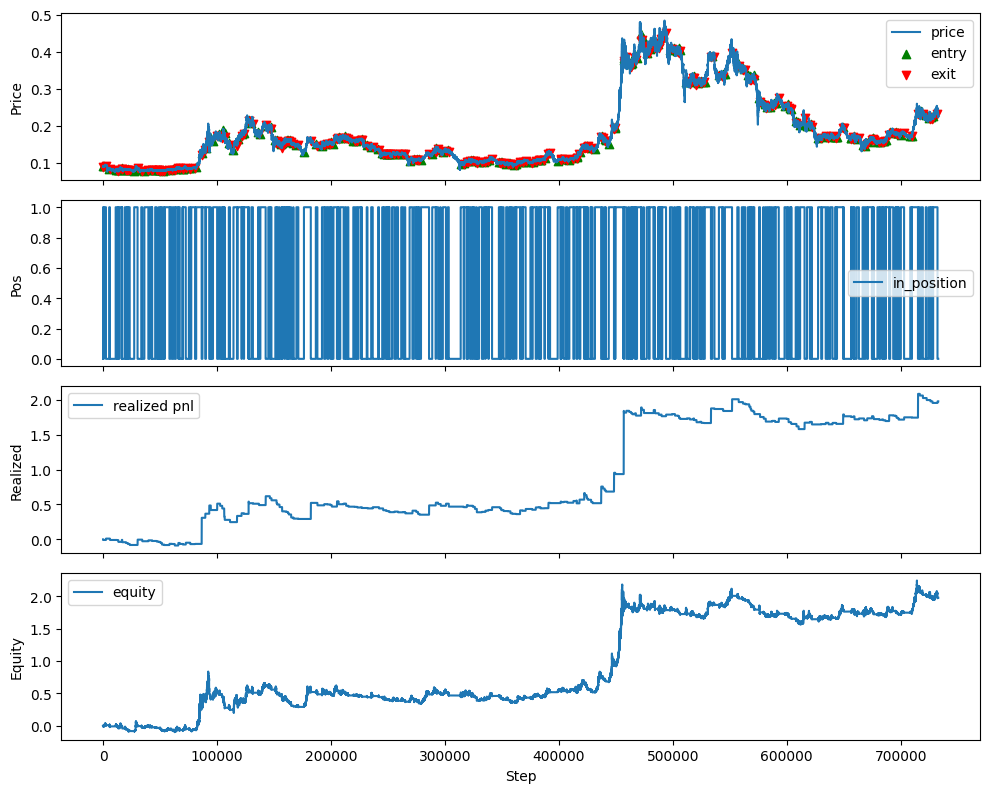

In [1]:
# @title Проверка среды на реальных данных LONG

import joblib
from numba import njit
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *

PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"

df = joblib.load(PATH_TO_DATA).iloc[-1000000:]

open_px  = df['Open'].to_numpy(np.float64)
high_px  = df['High'].to_numpy(np.float64)
low_px   = df['Low'].to_numpy(np.float64)
close_px = df['Close'].to_numpy(np.float64)
volum_px = df['Volume'].to_numpy(np.float64)

df['EMA_Fast'] = ema_numba(close_px, 750)
df['EMA_Slow'] = ema_numba(close_px, 1000)
df['ADX'] = adx_numba(high_px, low_px, close_px, 14)

# Добавляем сигнал референс стратегии
buy_sig  = (df['EMA_Fast'] > df['EMA_Slow']) & (df['Close'] > df['EMA_Fast']) & (df['ADX'] > 20)
sell_sig = (df['EMA_Fast'] < df['EMA_Slow']) & (df['Close'] < df['EMA_Fast']) & (df['ADX'] > 20)
df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)

def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['Signal_Rule']:
        action = 0
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.00005,         # без комиссии
    spread=0.0005,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

#проверка лонгов
environment = BacktestEnv(df, feature_cols=['EMA_Fast', 'EMA_Slow'], cfg = LONG_CONFIG, price_col='Open')
sim = run_backtest(df, environment)
logs = sim.logs()
print(logs.head(50).to_string())
print('Метрики: ')
print(sim.metrics_report())
fig = sim.plot()